# Pruning

In [1]:
import sys
sys.path.append("..")

In [2]:
from asyncio import MultiLoopChildWatcher
from doctest import OutputChecker

from turtle import hideturtle
import warnings

from models import GeneralModel
from models.statistics.Metrics import Metrics
from utils.config_utils import *
from utils.model_utils import *
from utils.system_utils import *

warnings.filterwarnings("ignore")

The Zen of Python, by Tim Peters

Beautiful is better than ugly.
Explicit is better than implicit.
Simple is better than complex.
Complex is better than complicated.
Flat is better than nested.
Sparse is better than dense.
Readability counts.
Special cases aren't special enough to break the rules.
Although practicality beats purity.
Errors should never pass silently.
Unless explicitly silenced.
In the face of ambiguity, refuse the temptation to guess.
There should be one-- and preferably only one --obvious way to do it.
Although that way may not be obvious at first unless you're Dutch.
Now is better than never.
Although never is often better than *right* now.
If the implementation is hard to explain, it's a bad idea.
If the implementation is easy to explain, it may be a good idea.
Namespaces are one honking great idea -- let's do more of those!


In [3]:
torch.__version__

'1.11.0+cu113'

In [49]:
# define arguments manually
arguments = argparse.Namespace()
# device
arguments.device = "cuda"

# define arguments for model
#arguments.model = "ResNet18" # ResNet not supported for structured
arguments.model = "MLP3"
arguments.hidden_dim = 64
#arguments.input_dim = None # for ResNet
#arguments.input_dim = (1,1,1) # for LeNet5
arguments.input_dim = (28,28) # for MNIST
arguments.output_dim = 10
arguments.disable_masking = 1 # 0 for disable mask, 1 for mask (unstructured)
arguments.track_weights = 0
arguments.enable_rewinding = 0
arguments.growing_rate = 0.0000
arguments.outer_layer_pruning = 0
# arguments.prune_criterion = "SNIPit"  # unstructured

arguments.prune_criterion = "SNAPit" # or SNAPit ... # structured
arguments.l0 = 0
arguments.l0_reg = 1.0
arguments.l1_reg = 0
arguments.lp_reg = 0
arguments.l2_reg = 5e-5
arguments.hoyer_reg = 0.001
arguments.N = 6000 # different for different dataset
arguments.beta_ema = 0.999


# define arguments for criterion
arguments.pruning_limit = 0.5
arguments.snip_steps = 6

# not pre-trained model
arguments.checkpoint_name = None
arguments.checkpoint_model = None

# dataset
arguments.data_set = "MNIST"
arguments.batch_size = 512
arguments.mean = (0.1307,)
arguments.std = (0.3081,)
arguments.tuning = 0
arguments.preload_all_data = 0
arguments.random_shuffle_labels = 0

# loss
arguments.loss = "CrossEntropy"

# optimizer
arguments.optimizer = "ADAM"
arguments.learning_rate = 2e-3

# training
arguments.save_freq = 1e6
arguments.eval = 0
arguments.train_scheme = "DefaultTrainer"
arguments.seed = 1234
arguments.epochs = 5

arguments.grad_noise = 0
arguments.grad_clip =10
arguments.eval_freq = 1000
arguments.max_training_minutes= 6120
arguments.plot_weights_freq = 50
arguments.prune_delay = 0
arguments.prune_freq = 1
arguments.rewind_to = 6

arguments.skip_first_plot = 0
arguments.disable_histograms = 0
arguments.disable_saliency = 0
arguments.disable_confusion = 0
arguments.disable_weightplot = 0
arguments.disable_netplot = 0
arguments.disable_activations = 0

arguments.pruning_rate = 0
# during training
arguments.pruning_freq = 1

In [50]:
metrics = Metrics()
out = metrics.log_line
print = out

ensure_current_directory()
global out 
out = metrics.log_line
out(f"starting at {get_date_stamp()}")

metrics._batch_size = arguments.batch_size
metrics._eval_freq = arguments.eval_freq

starting at 2022-04-19_18.55.09


In [51]:
device = configure_device(arguments)

In [52]:
# get model
model: GeneralModel = find_right_model(
        NETWORKS_DIR,arguments.model,
        device=device,
        hidden_dim = arguments.hidden_dim,
        input_dim = arguments.input_dim,
        output_dim = arguments.output_dim,
        is_maskable=arguments.disable_masking,
        is_tracking_weights=arguments.track_weights,
        is_rewindable=arguments.enable_rewinding,
        is_growable=arguments.growing_rate > 0,
        outer_layer_pruning=arguments.outer_layer_pruning,
        maintain_outer_mask_anyway=(
                                       not arguments.outer_layer_pruning) and (
                                           "Structured" in arguments.prune_criterion),
        l0=arguments.l0,
        l0_reg=arguments.l0_reg,
        N=arguments.N,
        beta_ema=arguments.beta_ema,
        l2_reg=arguments.l2_reg
    ).to(device)

In [53]:
for key,param in model.named_parameters():
    print(param.size())

torch.Size([64, 784])
torch.Size([64])
torch.Size([64, 64])
torch.Size([64])
torch.Size([10, 64])
torch.Size([10])


In [54]:
# get criterion
criterion = find_right_model(
        CRITERION_DIR,arguments.prune_criterion,
        model=model,
        limit=arguments.pruning_limit,
        start=0.5,
        steps=arguments.snip_steps,
        device=arguments.device
    )   

In [55]:
def load_checkpoint(arguments, metrics, model):
    if (not (arguments.checkpoint_name is None)) and (not (arguments.checkpoint_model is None)):
        path = os.path.join(RESULTS_DIR, arguments.checkpoint_name, MODELS_DIR, arguments.checkpoint_model)
        state = DATA_MANAGER.load_python_obj(path)
        try:
            model.load_state_dict(state)
        except KeyError as e:
            print(list(state.keys()))
            raise e
        out(f"Loaded checkpoint {arguments.checkpoint_name} from {arguments.checkpoint_model}")

# load pre-trained weights if specified
load_checkpoint(arguments, metrics, model)  

In [56]:
# load data
train_loader, test_loader = find_right_model(
        DATASETS, arguments.data_set,
        arguments=arguments,
        mean=arguments.mean,
        std=arguments.std
    )

Using mean (0.1307,)


In [57]:
# get loss function
loss = find_right_model(
        LOSS_DIR, arguments.loss,
        device=device,
        l1_reg=arguments.l1_reg,
        lp_reg=arguments.lp_reg,
        l0_reg=arguments.l0_reg,
        hoyer_reg=arguments.hoyer_reg
    )

In [58]:
# get optimizer
optimizer = find_right_model(
        OPTIMS, arguments.optimizer,
        params=model.parameters(),
        lr=arguments.learning_rate,
        weight_decay=arguments.l2_reg if not arguments.l0 else 0
    )


In [59]:
if not arguments.eval:
    # build trainer
    run_name = f'_model={arguments.model}_dataset={arguments.data_set}_prune-criterion={arguments.prune_criterion}' + \
               f'_pruning-limit={arguments.pruning_limit}_train-scheme={arguments.train_scheme}_seed={arguments.seed}'
    trainer = find_right_model(
            TRAINERS_DIR, arguments.train_scheme,
            model=model,
            loss=loss,
            optimizer=optimizer,
            device=device,
            arguments=arguments,
            train_loader=train_loader,
            test_loader=test_loader,
            metrics=metrics,
            criterion=criterion,
            run_name = run_name
        )

Made datestamp: 2022-04-19_18.55.13_model=MLP3_dataset=MNIST_prune-criterion=SNAPit_pruning-limit=0.5_train-scheme=DefaultTrainer_seed=1234


In [60]:
trainer.train()

Started training
Saved results/2022-04-19_18.55.13_model=MLP3_dataset=MNIST_prune-criterion=SNAPit_pruning-limit=0.5_train-scheme=DefaultTrainer_seed=1234/output/scores
pruning 24304 percentage 0.484375 length_nonzero 50176
pruning 3073 percentage 0.750244140625 length_nonzero 4096
pruning 330 percentage 0.515625 length_nonzero 640
  (layers): Sequential(
    (0): ContainerLinear(in_features=784, out_features=33.0, bias=True)
    (2): ContainerLinear(in_features=33.0, out_features=31.0, bias=True)
    (4): ContainerLinear(in_features=31.0, out_features=10, bias=True)
final percentage after snap: 0.5045709498834499
Saved results/2022-04-19_18.55.13_model=MLP3_dataset=MNIST_prune-criterion=SNAPit_pruning-limit=0.5_train-scheme=DefaultTrainer_seed=1234/output/scores
pruning 0 percentage 0.0 length_nonzero 25872
pruning 33 percentage 0.03225806451612903 length_nonzero 1023
pruning 10 percentage 0.03225806451612903 length_nonzero 310
  (layers): Sequential(
    (0): ContainerLinear(in_featu

<Figure size 432x288 with 0 Axes>

In [61]:
for key,param in model.named_parameters():
    print(param.size())

torch.Size([33, 784])
torch.Size([33])
torch.Size([30, 33])
torch.Size([30])
torch.Size([10, 30])
torch.Size([10])


# Verify

In [62]:
img,label=next(iter(test_loader))
img_test = img[0].squeeze().to(device)

In [63]:
# vanilla verify
num_classes = model.output_dim
c = model(img_test.reshape(1,-1)).argmax().item()
other_classes = set(range(num_classes))

In [64]:
num_classes,c,other_classes

(10, 7, {0, 1, 2, 3, 4, 5, 6, 7, 8, 9})

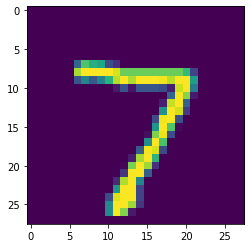

In [65]:
img=img_test.cpu().numpy()
import matplotlib.pyplot as plt
plt.imshow(img)

In [66]:
img_test = img_test.cpu().numpy().reshape(-1)
print(img_test.shape)

(784,)


In [67]:
from verify_utils.verify_utils import get_params_list,get_lower_and_upper_bounds

In [70]:
W,b = get_params_list(model)
num_layers = len(W)
eps=0.2

In [71]:
L,U = get_lower_and_upper_bounds(img_test,eps,W,b)

In [72]:
shapes=[]
for i in range(num_layers):
    shapes.append(U[i].shape[0])
    # add output shape
shapes.append(num_classes)
print(shapes)

[784, 33, 30, 10]


In [73]:
import cvxpy as cp 
X_hat = []
Y = []
A = []
for i in range(num_layers):
    X_hat.append(cp.Variable(shape=shapes[i]))
    Y.append(cp.Variable(shape=shapes[i+1]))
    if i != (num_layers-1):    
        A.append(cp.Variable(shape=shapes[i+1],boolean=True))

In [74]:
constraints = []
for j in range(num_layers-1):
    # Linear for layer j
    if j==0:
        constraints += [X_hat[j+1]==W[j]@X_hat[j]+b[j]]
    else:
        constraints += [X_hat[j+1]==W[j]@Y[j-1]+b[j]]
    constraints += [Y[j][i] <= X_hat[j+1][i] - L[j+1][i] * (1 - A[j][i]) for i in range(Y[j].shape[0])]
    constraints += [Y[j][i] >= X_hat[j+1][i] for i in range(Y[j].shape[0])]
    constraints += [Y[j][i] <= U[j+1][i] * A[j][i] for i in range(Y[j].shape[0])]
    constraints += [Y[j][i] >= 0 for i in range(Y[j].shape[0])]     

In [75]:
from tqdm.auto import tqdm
for other in tqdm(other_classes):
    problem = cp.Problem(objective=cp.Minimize(Y[-1][c]-Y[-1][other]),
                            constraints = constraints+[cp.atoms.norm_inf(img_test-X_hat[0]) <= eps,
                                                     #cp.norm2(X_hat[0]-img_test)<=eps,
                                                       Y[-1]== W[-1]@Y[-2]+b[-1]]
                        )
    opt = problem.solve('MOSEK')
    print(opt)
    if opt<0:
        print('found solution')
        break

  0%|          | 0/10 [00:00<?, ?it/s]

-1.2435075310498513
found solution


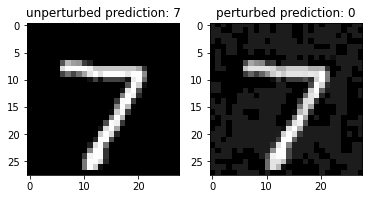

In [76]:
plt.subplot(121)
plt.imshow(img_test.reshape(28,28), cmap='gray')
plt.title(f"unperturbed prediction: {c}")
plt.subplot(122)
plt.imshow(X_hat[0].value.reshape(28, 28), cmap='gray')
plt.title(f"perturbed prediction: {Y[-1].value.argmax()}")
plt.show()

In [77]:
from verify_utils.verify_utils import verify_single_image

In [81]:
img,label=next(iter(test_loader))
img_test = img[0].squeeze().to(device)

In [82]:
img,label=verify_single_image(model,img_test,0.2)

  0%|          | 0/9 [00:00<?, ?it/s]

found solution


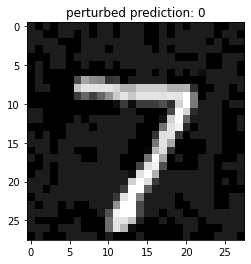

In [84]:
plt.imshow(img.value.reshape(28, 28), cmap='gray')
plt.title(f"perturbed prediction: {label.value.argmax()}")
plt.show()